In [2]:
import pandas as pd
import numpy as np
import sklearn

In [3]:
stocks = pd.read_csv('data_challenge_stock_prices.csv')
index = pd.read_csv('data_challenge_index_prices.csv')

In [4]:
def getBPS(df):
    mat = df.to_numpy()
    returns = (mat[1:] - mat[:len(mat)-1])/mat[:len(mat)-1]
    return returns * 10000

In [5]:
index.shape

(200000, 15)

In [6]:
st = getBPS(stocks)
indices = getBPS(index)

In [7]:
st.shape

(199999, 100)

In [8]:
from scipy import stats

In [9]:
corr = np.zeros((100,100))

In [10]:
for i in range(100):
    for j in range(100):
        corr[i][j] = stats.pearsonr(st[:,i],st[:,j])[0]

In [11]:
maxcorr = np.zeros(100,dtype=np.int32)
for i in range(100):
    ind = (i+1)%100
    for j in range(100):
        if i==j:
            continue
        if corr[i][j]>corr[i][ind]:
            ind = j
    maxcorr[i] = ind

In [12]:
maxcorr

array([88, 90, 98, 98, 88, 97, 98, 98, 99, 98, 90, 88, 99, 97, 88, 97, 98,
       98, 88, 98, 88, 88, 88, 98, 97, 88, 88, 99, 98, 99, 99, 97, 98, 98,
       97, 97, 99, 97, 88, 88, 99, 99, 98, 88, 99, 88, 99, 98, 97, 88, 99,
       98, 99, 98, 88, 99, 97, 99, 98, 99, 98, 97, 97, 98, 97, 97, 98, 88,
       97, 99, 97, 99, 98, 99, 99, 88, 97, 99, 88, 88, 99, 98, 88, 97, 99,
       97, 97, 98, 90, 97, 88, 98, 99, 97, 97, 97, 99, 95, 91, 96])

In [13]:
buckets = {i:[] for i in maxcorr}

In [14]:
for i in range(100):
    buckets[maxcorr[i]].append(i)

In [15]:
for i in buckets:
    print(i,buckets[i])

88 [0, 4, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 90]
90 [1, 10, 88]
98 [2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91]
97 [5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95]
99 [8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96]
95 [97]
91 [98]
96 [99]


In [16]:
buckets[88].extend(buckets[90])
buckets.pop(90)
buckets.pop(95)
buckets.pop(91)
buckets.pop(96)
buckets[98].append(98)
buckets[97].append(97)
buckets[99].append(99)

In [17]:
sectors = []
for i in buckets:
    sectors.append(buckets[i])
sectors = np.array(sectors)
sectors.shape

(4, 25)

In [18]:
# np.save("sectors.npy",sectors)
sectors = np.load('sectors.npy')

In [19]:
def correlation(vec1, vec2):
    dim1 = vec1.shape[1]
    dim2 = vec2.shape[1]
    correl = np.zeros((dim1,dim2),dtype=np.float32)
    for i in range(dim1):
        for j in range(dim2):
            correl[i][j] = stats.pearsonr(vec1[:,i],vec2[:,j])[0]
    return correl

In [20]:
import seaborn as sbn

In [21]:
stock_sectorwise = np.array([st[:,sectors[i]] for i in range(4)])

In [22]:
import matplotlib.pyplot as plt

In [23]:
# for i in range(4):
#     for j in range(i,4):
#         plt.title(f"Sector {i} vs Sector {j}")
#         sbn.heatmap(correlation(stock_sectorwise[i],stock_sectorwise[j]),vmin=0,vmax=0.5)
#         plt.show()

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
def test(Func):   
    pred_corr = np.zeros((15,4))
    for i in range(4):
        for j in range(15):
            x = stock_sectorwise[i]     # 199999,25
            y = indices                 # 199999,1
            x_tr = x[0:12000]
            x_te = x[12000:]
            y_tr = y[0:12000,j]
            y_te = y[12000:,j]
            model = Func()
            model.fit(x_tr,y_tr)
            y_pred = model.predict(x_te)
            pecorr = stats.pearsonr(y_te[:],y_pred[:])[0]
            pred_corr[j][i] = pecorr
    
    posn = np.argmax(pred_corr,axis=1)
    for i in range(15):
        print(i,pred_corr[i],posn[i])
    return pred_corr


In [26]:
from sklearn.neural_network import MLPRegressor

In [25]:
print("Linear")
pc = test(LinearRegression)

Linear
0 [0.44428666 0.08731293 0.08200398 0.08465401] 0
1 [0.05599844 0.05183528 0.31142448 0.05264355] 2
2 [0.20657407 0.01151913 0.01726661 0.01918735] 0
3 [0.0298753  0.34350168 0.02661995 0.02855217] 1
4 [0.09505984 0.07339035 0.08738046 0.44746208] 3
5 [0.01818233 0.0265306  0.21575747 0.0275874 ] 2
6 [0.08724768 0.44362346 0.09761592 0.08195443] 1
7 [0.30144975 0.05163767 0.05164508 0.05090786] 0
8 [0.04894639 0.30381171 0.05049344 0.05297393] 1
9 [0.02944939 0.02110999 0.03250083 0.34517321] 3
10 [0.01015871 0.02096384 0.3408217  0.01171519] 2
11 [-0.00015145  0.00158011 -0.00180775 -0.00240251] 1
12 [ 0.00549766 -0.00246269  0.00126297 -0.00114666] 0
13 [-0.00341212  0.00479849  0.00124561 -0.00108384] 1
14 [0.01209144 0.00158175 0.00911624 0.20853675] 3


In [27]:
# For all except 11,12 and 13, we have figured out which sector.

In [28]:
# print("MLP")
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     pred_corr = test(MLPRegressor)

In [29]:
# A simple neural net gave reasonable correlation for all indices including 11,12 and 13. 

In [27]:
index_sector = {0:0,1:2,2:0,3:1,4:3,5:2,6:1,7:0,8:1,9:3,10:2,11:0,12:3,13:1,14:3}

In [27]:
def train_and_evaluate(ind_num,sector_num,train_len,test_len,model, do_scale=False, do_poly=-1):
    train_x = stock_sectorwise[sector_num][:train_len]
    train_y = indices[:train_len,ind_num]
    test_x = stock_sectorwise[sector_num][train_len:train_len+test_len]
    test_y = indices[train_len:train_len+test_len,ind_num]

    print(train_y.shape, test_y.shape)

    if do_scale:
        # scale data
        scaler_x = sklearn.preprocessing.StandardScaler().fit(train_x)
        train_x = scaler_x.transform(train_x)
        test_x = scaler_x.transform(test_x)
        scaler_y = sklearn.preprocessing.StandardScaler().fit(train_y.reshape(-1, 1))
        train_y = scaler_y.transform(train_y.reshape(-1, 1))

    if do_poly != -1:
        poly = sklearn.preprocessing.PolynomialFeatures(degree=do_poly)
        train_x = poly.fit_transform(train_x)
        test_x = poly.fit_transform(test_x)

    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)

    if do_scale:
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))

    pecorr = stats.pearsonr(test_y,y_pred)[0]
    print(f"Predictive correlation for index {ind_num} : {pecorr}")
    return model

In [101]:
train_len = 160000-1
test_len = 40000

In [88]:
#Index 0:
#Linear Model
ind_num = 0
sector_num = index_sector[ind_num]
mod0 = LinearRegression()                               # 44%
# mod0 = sklearn.linear_model.Ridge()
# mod0 = sklearn.svm.SVR()      # quadratic times
# mod0 = MLPRegressor(hidden_layer_sizes=128)           # 40%
mod0 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod0)

(159999,) (40000,)
Predictive correlation for index 0 : 0.44672797701419487


In [33]:
# from sklearn.kernel_ridge import KernelRidge
from sklearn import tree

In [114]:
#Index 1:
#Neural Net
ind_num = 1
sector_num = index_sector[ind_num]
mod1 = MLPRegressor(hidden_layer_sizes=100)
# mod1 = LinearRegression()
# mod1 = tree.DecisionTreeRegressor()       # 17%
mod1 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod1, do_scale=True)

# [MLP 100] scaling gave a 1% increase
# Linear+poly-2: 37%

In [102]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [103]:
ind_num = 1
sector_num = index_sector[ind_num]

train_x = stock_sectorwise[sector_num][:train_len]
train_y = indices[:train_len,ind_num]
test_x = stock_sectorwise[sector_num][train_len:train_len+test_len]
test_y = indices[train_len:train_len+test_len,ind_num]

loader_kwargs = {
    'batch_size': 1024
}
train_loader = DataLoader(
    TensorDataset(torch.Tensor(train_x),torch.Tensor(train_y)), **loader_kwargs
)

test_loader = DataLoader(
    TensorDataset(torch.Tensor(test_x),torch.Tensor(test_y)), **loader_kwargs
)

In [108]:
class MLP_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(25, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP_Model()
optim = torch.optim.Adam(model_mlp.parameters(), lr=5e-4)
loss = torch.nn.MSELoss()

In [109]:
def train(model, optimizer, train_loader, loss_fn, num_epochs, test_loader=None):
    dict_losses = {
        "epoch": [],
        "train_loss": [],
    }
    if test_loader is not None:
        dict_losses["test_loss"] = []
    
    print_width = max(1, num_epochs/10)

    for epoch in range(num_epochs):
        train_loss = 0
        cnt_tr = 0

        model.train()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs).flatten()

            # print(outputs.shape, labels.shape)
            assert outputs.shape==labels.shape                  # useful check

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            cnt_tr += 1

        dict_losses["epoch"].append(epoch)
        dict_losses["train_loss"].append(train_loss/cnt_tr)

        if test_loader is not None:
            model.eval()
            with torch.no_grad():
                test_loss = 0
                cnt = 0
                for inputs, labels in test_loader:
                    outputs = model(inputs).flatten()
                    loss = loss_fn(outputs, labels)
                    test_loss += loss.item()
                    cnt += 1
            dict_losses["test_loss"].append(test_loss/cnt)

        if epoch%print_width==0:
            print("Epoch:", epoch, "\tTrain Loss:", train_loss/cnt_tr)
        
    return dict_losses

In [110]:
dict_losses = train(model_mlp, optim, train_loader, loss, 100, test_loader)

Epoch: 0 	Train Loss: 0.6307357948297149
Epoch: 10 	Train Loss: 0.5718700323894526
Epoch: 20 	Train Loss: 0.561849817538717
Epoch: 30 	Train Loss: 0.5570126883922868
Epoch: 40 	Train Loss: 0.5539710333772526
Epoch: 50 	Train Loss: 0.551868370194344
Epoch: 60 	Train Loss: 0.5503897963056139
Epoch: 70 	Train Loss: 0.5492561620891474
Epoch: 80 	Train Loss: 0.5482859453957551
Epoch: 90 	Train Loss: 0.5474019637153407


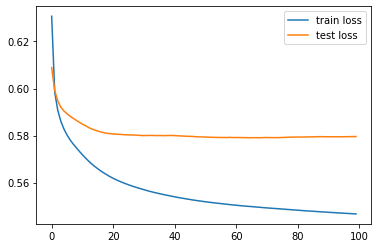

In [111]:
plt.plot(dict_losses['epoch'], dict_losses['train_loss'], label='train loss')
plt.plot(dict_losses['epoch'], dict_losses['test_loss'], label='test loss')
plt.legend()
plt.show()

In [113]:
model_mlp.eval()
with torch.no_grad():
    l_in = []
    l_lbl = []
    for inputs, labels in test_loader:
        l_in.append(model_mlp(inputs).flatten())
        l_lbl.append(labels)
    in_arr = np.concatenate(l_in)
    lbl_arr = np.concatenate(l_lbl)
    pecorr = stats.pearsonr(lbl_arr,in_arr)[0]
print(pecorr)

0.38924997409319567


In [33]:
#Index 2:
#Neural Net
ind_num = 2
sector_num = index_sector[ind_num]
mod2 = MLPRegressor(hidden_layer_sizes=(20))
mod2 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod2)

(159999,) (40000,)
Predictive correlation for index 2 : 0.5891001649291996


In [34]:
#Index 3:
#Neural Net
ind_num = 3
sector_num = index_sector[ind_num]
mod3 = MLPRegressor(hidden_layer_sizes=(5))
mod3 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod3)

(159999,) (40000,)
Predictive correlation for index 3 : 0.43961652493707254


In [35]:
#Index 4:
#Linear Model
ind_num = 4
sector_num = index_sector[ind_num]
# mod4 = LinearRegression()
mod4 = MLPRegressor(hidden_layer_sizes=20)
mod4 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod4)

(159999,) (40000,)
Predictive correlation for index 4 : 0.44630110708538284


In [36]:
#Index 5:
#Neural Net
ind_num = 5
sector_num = index_sector[ind_num]
mod5 = MLPRegressor(hidden_layer_sizes=(10))
mod5 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod5)

(159999,) (40000,)
Predictive correlation for index 5 : 0.5621079613598187


In [37]:
#Index 6:
#Neural Net
ind_num = 6
sector_num = index_sector[ind_num]
mod6 = MLPRegressor(hidden_layer_sizes=(5))
# mod6 = LinearRegression()           # almost the same as MLP-5
mod6 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod6)

(159999,) (40000,)
Predictive correlation for index 6 : 0.44558307756336796


In [38]:
#Index 7:
#Neural Net
ind_num = 7
sector_num = index_sector[ind_num]
mod7 = MLPRegressor(hidden_layer_sizes=(80))
# mod7 = LinearRegression()     # usual:30%, scale+deg-2:36%
mod7 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod7)

# lin-reg: 30%
# lin + [scale] + deg-2: 36%
# MLP-20: 36%
# MLP-80: 40%

(159999,) (40000,)
Predictive correlation for index 7 : 0.3649918985105094


/home/govind/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
#Index 8:
#Neural Net
ind_num = 8
sector_num = index_sector[ind_num]
mod8 = MLPRegressor(hidden_layer_sizes=(80))
mod8 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod8)

(159999,) (40000,)


In [ ]:
#Index 9:
#Neural Net
ind_num = 9
sector_num = index_sector[ind_num]
mod9 = MLPRegressor(hidden_layer_sizes=(80))
mod9 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod9)

In [ ]:
#Index 10:
#Neural Net
ind_num = 10
sector_num = index_sector[ind_num]
mod10 = MLPRegressor(hidden_layer_sizes=(80))
mod10 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod10)

In [ ]:
#Index 11:
#Neural Net
ind_num = 11
sector_num = index_sector[ind_num]
mod11 = MLPRegressor(hidden_layer_sizes=(80))
mod11 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod11)

In [ ]:
#Index 12:
#Neural Net
ind_num = 12
sector_num = index_sector[ind_num]
mod12 = MLPRegressor(hidden_layer_sizes=(80))
mod12 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod12)

In [ ]:
#Index 13:
#Neural Net
ind_num = 13
sector_num = index_sector[ind_num]
mod13 = MLPRegressor(hidden_layer_sizes=(80))
mod13 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod13)

In [ ]:
#Index 14:
#Neural Net
ind_num = 14
sector_num = index_sector[ind_num]
mod14 = MLPRegressor(hidden_layer_sizes=(20))
mod14 = train_and_evaluate(ind_num,sector_num,train_len,test_len,mod14)

In [ ]:
models = []

import joblib

# for i,mod in enumerate(models):
#     joblib.dump(mod, f'models/{i}.pkl')

for i in range(15):
    models.append(joblib.load(f'models/{i}.pkl'))

In [121]:
def predict(returns): #Takes stock returns as input, returns index return predictions.
    res = []
    for i in range(15):
        inp = returns[:,sectors[index_sector[i]]]
        res.append(models[i].predict(inp))
    
    return np.array(res).T

In [ ]:
predictions = predict(st[160000:])
covmat = ((predictions.T @ predictions)/len(predictions)) - np.outer(np.mean(predictions,axis=0),np.mean(predictions,axis=0))

In [15]:
covmat.diagonal()

array([1.55232620e+00, 2.40759108e+03, 4.51278900e-01, 2.46218576e+00,
       1.51903318e+00, 4.00497420e-01, 1.51050232e+00, 1.19767012e-01,
       1.19582003e-01, 2.50721004e+00, 2.50653915e+00, 7.63726201e-01,
       7.76832704e-01, 7.62416024e-01, 4.15769606e-01])

In [16]:
indices_to_trade = list(range(15))

In [17]:
timesteps = 40000
basev = 180000-1
stock_prices = st[basev:basev+timesteps]
pred = predict(stock_prices)[:,indices_to_trade]
cov_submat = covmat[indices_to_trade,:][:,indices_to_trade]

In [18]:
from scipy.optimize import minimize
def tradingstrategy(timestep,pred,cov_submat,indices_to_trade):
  # To return a portfolio of length timesteps, containing the position of each index we're trading in at time T

    def objective_func(portfolio,predictions):
        returns = np.dot(portfolio, predictions)
        var = np.dot(portfolio,np.dot(covmat[indices_to_trade,:][:,indices_to_trade],portfolio))
        return -returns/np.sqrt(var)
    
    portfolios = []
    for t in range(timesteps):
        return_pred = pred[t]
        init_guess = np.ones_like(return_pred)
        init_guess /= len(init_guess)
        bounds = [(-1,1) for i in range(len(init_guess))]
        constraints = ( {"type": "eq", "fun": lambda x: np.sum(x)})
        portf = minimize(lambda wt:objective_func(wt,return_pred),init_guess,  method="SLSQP", bounds = bounds, constraints = constraints ).x
        portfolios.append(portf)
        if t%1000==0:
            print(t)
    return portfolios

In [19]:
print(pred[0]/np.sqrt(cov_submat.diagonal()))

[ 1.50605219 -5.62340515  0.35278602 -0.78417665  0.8431377   3.13473069
  0.21869979  1.35551618  0.98358211 -0.13989541  0.231845    0.83115778
  0.44260166 -0.8270171   0.0534096 ]


In [ ]:
portfolios = tradingstrategy(timesteps, pred, cov_submat, indices_to_trade)

In [48]:
print(portfolios[0])
print(np.sum(portfolios[0]))
print(portfolios[1])
print(np.sum(portfolios[1]))

[ 0.26234949 -1.          0.09127622 -0.12425296  0.07530482  0.89215669
 -0.19529052 -0.18586834  0.66737643 -0.03410852 -0.14155274  0.09437389
 -0.04078634 -0.27609083 -0.0848873 ]
2.636779683484747e-16
[-1.64362799e-01  3.29810360e-01 -2.89402190e-01 -3.15511311e-02
  9.50277169e-04 -1.99575376e-01 -2.12638717e-01 -3.17213853e-01
  1.00000000e+00 -8.69741947e-02  8.54375367e-03  2.52891649e-01
 -1.44418665e-01 -2.68279501e-01  1.22220387e-01]
-2.7755575615628914e-17


In [49]:
index_prices = indices[basev:basev+timesteps,indices_to_trade]

return_perc = []
for a,b in zip(portfolios,index_prices):
    return_perc.append(np.dot(a,b))

print(np.mean(return_perc),np.std(return_perc))

3.0255621827591814 2.5370024977280132


In [50]:
3.02556/2.537002

1.1925729660441733